# Introducing the ABSESpy package

The following introduces the ABSESpy python package for individual-based simulations in the context of social-ecological systems. The package is designed to loosely integrate societal elements as well as environmental ones. In order to follow the tutorial, please make sure that you have it properly installed. 

```
%pip install --upgrade abses"
```

This introduction presents the basic structure of the package and its main components by means of building a simple model, illustrating each step of the process. The model chosen is an adaptation of the Hotelling's Law model. The counterpart written in Netlogo can be found [here](https://ccl.northwestern.edu/netlogo/models/Hotelling'sLaw). The Hotelling's Law, also referred to as the Law of minimum differentiation states that profit maximizing firms competing in a market with two substitute goods will settle close to each other and also lower their prices. Although the notion of distance relates to space both in the original paper by Hotelling (1929) and its netlogo implementation, its definition can be expanded to other dimensions of interest.

At the base of any ABSESpy model, there will be a Model instance and as many Actor instances as desired. For the following example we will require that there is a specific hotelling model class that will inherit from the base MainModel class. This class will contain all the specific methods and attributes that are required for the model to run. In this case, we will need to define the following:
- Clearly defined setup method
- Clearly defined step method
- Other functionalities to assist the setup and step method.

We will also need an class that inherits from Actor. We will call it shop to honor the original Hotelling's Law model and its netlogo implementation. For this class we will also write a setup and step method along with other functionalities that will be required for the model to run.

In [58]:
import numpy as np

from abses import Actor, MainModel
from abses.datacollection import DataCollector

# Define random number generator
rng = np.random.default_rng(seed=42)


class Shop(Actor):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)


class Hotelling(MainModel):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

Following the netlogo implementation, each agent will begin at a random position. It will have a market area or share depending on its price and position. Each cell or patch of the grid is considered a customer with inelastic demand for the product. Each customer will make a choice as to what shop is prefered based on the price and distance to each shop. In the original paper (1929) the distance to the shop introduces transportation costs.

We first may wish to work out all the setup before writing the instructions for each step.

Drawing attention to the Shop agent class first, we will put in place some class attributes as we initialize the class. We are going to take `__init__` method as our setup step. We will give our Shop agent the following parameters:

|attribute|description|
|---|---|
|price|Agent's price|
|area_count|Number of customer who prefer the shop|
|id|Shop's identifier|
|next_position|Position to advance to at the end of this period|
|next_price|Price to set at the end of this period|

The main control variables are the price and position. Area count is a variable that will be used by the agent to decide how to adjust its price and position but it won't be able to alter it. The agent's id is a unique 7-figure identifier. The next position and next price are the variables that will be used to store the agent's choices on position and price momentarily and that will take effect at the end of the period.

In [59]:
class Shop(Actor):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.price = 10
        self.area_count = 0
        self.id = rng.integers(
            1e6, 1e7, dtype=int  # FIXME: no two agent may have the same id
        )
        self.next_position = None
        self.next_price = None

In the case of the model object, the setup method has to be defined and it will be a bit more elaborate. As we initialize a model, we just want to pass one parameter to be stored as an attribute. This parameter is the number of shops that we want to have in the model.

In the setup method we will want to i. initialize a grid, ii. create the list of agents and iii. place the agents in the grid randomly. To perform these actions, ABSESpy provides extensive functionality as to make it seamless and quick. It is important, nonetheless, to become familiar with involved modules. Namely, there are two that are of interest for us now:

1. BaseNature
2. ActorsList

They are both used under the hood in the initialization of the model object. BaseNature provides us with the spatial component for our model. ActorsList is the container of all agents in the model. 

Another important element to out setup method is the initialization of the data collector class. This class will be used to store the data that we want to collect from the model. In this case, we will want to store the price and position of each shop at each step. We will also want to store the number of customers that each shop has at each step. This class inherits from the DataCollector class in mesa.

In [60]:
class Hotelling(MainModel):
    def __init__(self, N, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.num_agents = N

    def setup(self):
        # Initialize a grid of shape (12, 12)
        self.nature.create_module(how="from_resolution", shape=(12, 12))

        # Create a list of agents
        self.agents.create(Shop, self.num_agents)

        # Placed agents on the grid randomly
        positions = rng.integers(12, size=(self.num_agents, 2), dtype=np.int8)

        for i, agent in enumerate(self.actors):
            agent.put_on_layer(
                layer=self.nature.major_layer, pos=tuple(positions[i])
            )

        # Initialize a DataCollector object
        self.datacollector = DataCollector(
            self, agent_reporters={"Price": "price", "Area": "area_count"}
        )

The `step` method of the `Hotelling` model class is responsible for updating the state of the model at each time step. It will first call the a method to calculate the monopoly areas for each shop, and then assigns the area count to each shop. The reasoning being that at the end of each step all agents decisions will have affected the state of the environment, thus, we recalculate variables that are affected by changes instantiated by those decisions and update them. It then triggers all agents to step. Finally, it triggers the price and positional changes to take effect using the `advance` method each agent should have.

Notice how we are already making choices that will affect how the model will be further developed. For instance, now we now that our Shop agents should have, at least, two methods: one named `step` and another named `advance`. Also, the next step should consist of implementing the monopoly area calculation method.

In [61]:
class Hotelling(MainModel):
    def __init__(self, N, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.num_agents = N

    def setup(self):
        # Initialize a grid of shape (12, 12)
        self.nature.create_module(how="from_resolution", shape=(12, 12))

        # Create a list of agents
        self.agents.create(Shop, self.num_agents)

        # Placed agents on the grid randomly
        positions = rng.integers(12, size=(self.num_agents, 2), dtype=np.int8)

        for i, agent in enumerate(self.actors):
            agent.put_on_layer(
                layer=self.nature.major_layer, pos=tuple(positions[i])
            )

        # Initialize a DataCollector object
        self.datacollector = DataCollector(
            self, agent_reporters={"Price": "price", "Area": "area_count"}
        )

    def step(self):
        # recalculate areas and assign them to each agent
        areas = self.recalculate_areas()

        for shop in self.actors:
            shop.area_count = areas[shop]

        # trigger all agents to step
        self.actors.trigger("step")

        # let price and positional changes take effect
        self.actors.trigger("advance")

        # collect data
        self.datacollector.collect()

    def recalculate_areas(self):
        pass

 We will want to be able to calculate respective monopoly areas for each shop. Since no single agent can really set this variable for himself, this method must be implement within the scope of the Hotelling model class scope. Essentially, it will iterate through each path or cell and it will define what would be the preferred shop for a customer that sits on that cell. The area for any given Shop is the number of customer that prefer that shop.

 We are going to need a function to calculate the distance between any two points in the grid. We will use the euclidean distance. We proceed to take this distance as the nominal value of the transportation costs, assuming each unit of distance equates one unit of money.

 This distance plus the price will define the total costs that a customer incurs when buying from a given shop.

 The preferred shop will be the cheapest one. That is, the one for which the customer faces less costs for both the product itself and transportation. The method will return a dictionary with the number of customers that prefer each shop.

 Once it is done, we already should have finished the implementation of the Model class. It is important to note that the model class requires the setup and step methods since those control the most fundamental and basic aspects of the simulation. Further functionality may be added depending on the idiosyncratic needs of the researcher. In our case, we aim to keep things as simple as possible and only add a method to calculate each shops respective control areas since that variables should be given to the agents and taken as given by them.

In [62]:
# Calculate euclidean distance between two points
def euclidean_distance(x1, y1, x2, y2):
    return np.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)

In [63]:
class Hotelling(MainModel):
    def __init__(self, N, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.num_agents = N

    def setup(self):
        # Initialize a grid of shape (12, 12)
        self.nature.create_module(how="from_resolution", shape=(12, 12))

        # Create a list of agents
        self.agents.create(Shop, self.num_agents)

        # Placed agents on the grid randomly
        positions = rng.integers(12, size=(self.num_agents, 2), dtype=np.int8)

        for i, agent in enumerate(self.actors):
            agent.put_on_layer(
                layer=self.nature.major_layer, pos=tuple(positions[i])
            )

        # Initialize a DataCollector object
        self.datacollector = DataCollector(
            self, agent_reporters={"Price": "price", "Area": "area_count"}
        )

    def step(self):
        # recalculate areas and assign them to each agent
        areas = self.recalculate_areas()

        for shop in self.actors:
            shop.area_count = areas[shop]

        # trigger all agents to step
        self.actors.trigger("step")

        # let price and positional changes take effect
        self.actors.trigger("advance")

        # collect data
        self.datacollector.collect()

    def recalculate_areas(self):
        areas = {}

        for shop in self.actors:
            areas[shop] = 0

        _width = self.nature.major_layer.width  # columns
        _height = self.nature.major_layer.height  # rows

        for i in range(_height):
            for j in range(_width):
                dist = {}
                for shop in self.actors:
                    _dist = (
                        euclidean_distance(i, j, shop.pos[0], shop.pos[1])
                        + shop.price
                    )
                    dist[shop] = _dist
                _choice = min(dist, key=dist.get)
                areas[_choice] += 1

        return areas

Now we shift out attention to the Shop agent class. From the previous implementation of the Hotelling model class, we already have cues as to what we should aim for and tackle. We know there must be a step and an advance method. We also know that the agent must make a decision regarding price and position based on the number of customer that prefer buying from them, thus, increasing profits and staying in business. Therefore, we will design the Shop agent class in a way that reflect this. There will be the two methods already mentioned and for each there will be two routines. 

First, the `step` method will be called for all agents. In it, there will be two routines regarding the changes in prices and positions respectively. At each step, each agent is going to adjust its price and position, but those changes will only take effect at a later stage. The reason for this is that we want to make sure that all agents have made their decisions before any of them takes effect. This may also be referred to as a synchronous or simultaneous update. In order to do that, we want to save the changes in a variable that will be used to update the agent's attributes at the end of the step. This is the reason behing having the `next_price` and `next_position` attributes. 

In [64]:
class Shop(Actor):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.price = 10
        self.area_count = 0
        self.id = rng.integers(
            1e6, 1e7, dtype=int  # FIXME: no two agent may have the same id
        )
        self.next_position = None
        self.next_price = None

    def step(self):
        self.adjust_price()
        self.adjust_position()

    def advance(self):
        self.affect_price()
        self.affect_position()

    def adjust_price(self):
        pass

    def adjust_position(self):
        pass

    def affect_price(self):
        pass

    def affect_position(self):
        pass

The price adjustme schedule are part of the `Shop` class in the Hotelling model. There are two methods that relate to this procedure, namely, `adjust_price` and `adjust_position`. Here's a detailed description of how it works:

1. **adjust_price**: This method is responsible for determining the next price for the shop based on potential revenues.

   - It first saves the current price of the shop in `initial_price`.
   
   - It then creates a list of possible prices, which are the current price minus 1, the current price, and the current price plus 1.
   
   - For each possible price, it temporarily sets the shop's price to that value and calculates the potential revenue if the shop were to sell at that price. The potential revenue is calculated as the product of the price and the area of the shop's monopoly, which is obtained by calling the `recalculate_areas` method of the model.
   
   - If all potential revenues are 0, it sets `next_price` to be the current price minus 1. This means that if the shop cannot make any revenue at any of the possible prices, it will lower its price in the next step.
   
   - If there is at least one possible price that can generate revenue, it sets `next_price` to be the one that generates the highest potential revenue.
   
   - Finally, it resets the shop's price to the initial price. This is because the actual price change does not occur in the `adjust_price` method. Instead, the new price is stored in `next_price` and the price change is applied in the `affect_price` method.

2. **affect_price**: This method is responsible for applying the price change that was determined in the `adjust_price` method.

   - It simply sets the shop's price to `next_price`. This is the new price that was determined in the `adjust_price` method.

The `adjust_price` and `affect_price` methods are called in the `step` and `advance` methods of the `Shop` class, respectively. This allows all shops to make their decisions based on the current state of the model in the `step` method, and then all decisions are applied simultaneously in the `advance` method.

In [65]:
class Shop(Actor):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.price = 10
        self.area_count = 0
        self.id = rng.integers(
            1e6, 1e7, dtype=int  # FIXME: no two agent may have the same id
        )
        self.next_position = None
        self.next_price = None

    def step(self):
        self.adjust_price()
        self.adjust_position()

    def advance(self):
        self.affect_price()
        self.affect_position()

    def adjust_price(self):
        # Save initial price
        initial_price = self.price

        # Build a list of all possible prices
        _possible_prices = [self.price - 1, self.price, self.price + 1]

        # Pair each possible price change to its potential revenue
        _potential_revenues = {}
        for price in _possible_prices:
            self.price = price
            _potential_revenues[price] = (
                self.model.recalculate_areas()[self] * price
            )
        # Check if all potential revenues are 0
        # if so, decrease price by 1
        if all(value == 0 for value in _potential_revenues.values()):
            self.next_price = self.price - 1
        # Otherwise, choose the price with the highest potential revenue
        else:
            self.next_price = max(
                _potential_revenues, key=_potential_revenues.get
            )

        # Reset price to initial price
        self.price = initial_price

    def adjust_position(self):
        pass

    def affect_price(self):
        self.price = self.next_price

    def affect_position(self):
        pass

Next we write the methods relating to the position adjustment schedule. Here's a detailed description of how they work:

1. **adjust_position**: This method is responsible for determining the next position for the shop based on potential areas.

   - It first saves the current position of the shop in `initial_pos`.
   
   - It then gets a list of all possible moves the shop can make. This is done by calling the `get_neighborhood` method of the `major_layer` attribute of the model, which returns the neighboring cells of the shop's current position. The `major_layer` is a BaseNature instance that represent one grid of the model.
   
   - For each possible move, it temporarily moves the shop to that position and calculates the potential area of the shop's monopoly if it were to move to that position. The potential area is calculated by calling the `recalculate_areas` method of the model.
   
   - It then selects the move that results in the largest potential area and stores it in `next_position`.
   
   - Finally, it moves the shop back to its initial position. This is because the actual move does not occur in the `adjust_position` method. Instead, the new position is stored in `next_position` and the move is applied in the `affect_position` method.

2. **affect_position**: This method is responsible for applying the move that was determined in the `adjust_position` method.

   - It simply moves the shop to `next_position`. This is the new position that was determined in the `adjust_position` method.

The `adjust_position` and `affect_position` methods are called in the `step` and `advance` methods of the `Shop` class, respectively. This allows all shops to make their decisions based on the current state of the model in the `step` method, and then all decisions are applied simultaneously in the `advance` method.

In [66]:
class Shop(Actor):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.price = 10
        self.area_count = 0
        self.id = rng.integers(
            1e6, 1e7  # FIXME: no two agents should have the same id
        )
        self.next_position = None
        self.next_price = None

    def step(self):
        self.adjust_price()
        self.adjust_position()

    def advance(self):
        self.affect_price()
        self.affect_position()

    def adjust_price(self):
        # Save initial price
        initial_price = self.price

        # Build a list of all possible prices
        _possible_prices = [self.price - 1, self.price, self.price + 1]

        # Pair each possible price change to its potential revenue
        _potential_revenues = {}
        for price in _possible_prices:
            self.price = price
            _potential_revenues[price] = (
                self.model.recalculate_areas()[self] * price
            )
        # Check if all potential revenues are 0
        # if so, decrease price by 1
        if all(value == 0 for value in _potential_revenues.values()):
            self.next_price = self.price - 1
        # Otherwise, choose the price with the highest potential revenue
        else:
            self.next_price = max(
                _potential_revenues, key=_potential_revenues.get
            )

        # Reset price to initial price
        self.price = initial_price

    def adjust_position(self):
        # Save initial position
        initial_pos = self.pos

        # Get all possible candidates for the next position
        _possible_moves = self.model.nature.major_layer.get_neighborhood(
            self.pos, moore=True, include_center=False
        )
        # Pair each possible move to their potential areas
        _potential_areas = {}
        for move in _possible_moves:
            self.move_to(move)
            _potential_areas[move] = self.model.recalculate_areas()[self]

        # Single out the store with the highest potential area and savi it
        _choice = max(_potential_areas, key=_potential_areas.get)
        self.next_position = _choice

        # Pull back to initial position if the potential area
        self.move_to(initial_pos)

    def affect_price(self):
        self.price = self.next_price

    def affect_position(self):
        self.move_to(self.next_position)

Once we have a full working and testable version of our model, we instantiate it and run it. The following code block shows how to do this:

1. **Define the Parameters**

   The `parameters` dictionary is defining the parameters for the simulation. In this case, there's only one parameter: `end`. This parameter is nested under `time` and is set to `100`. This means the simulation will run for 100 time steps.

2. **Instantiate the Model**

   The `Hotelling` model is being instantiated with `N=2` and `parameters=parameters`. This means that the model will start with 2 agents (as specified by `N=2`) and will use the parameters defined in the `parameters` dictionary. 

3. **Run the Model**

   The `run_model` method is called on the `model` instance. This starts the simulation and runs it until the end time specified in the parameters (in this case, 100 time steps).

The `Hotelling` model is a type of agent-based model used in economics to simulate competition between two firms (or agents) in a geographical market. The `N=2` parameter suggests that there are two firms in the simulation. The firms adjust their prices and locations in each time step based on the state of the market, and the simulation tracks these adjustments over time.

In [67]:
parameters = {
    "time": {
        "end": 100,
    }
}

model = Hotelling(N=2, parameters=parameters)

model.run_model()

tick[15] 2023-11-25 10:38:01

tick[100] 2023-11-25 10:38:01

We now have a working model. The `datacollector` attribute allows to access data collected during the execution of the model. We mainly want to observe the evolution of key variables that describe model's state. For this example, we want to observe the price of each shop at each time step. We also want to observe the number of customers that prefer each shop at each time step. The following code block shows how to do this:

<Axes: xlabel='Step'>

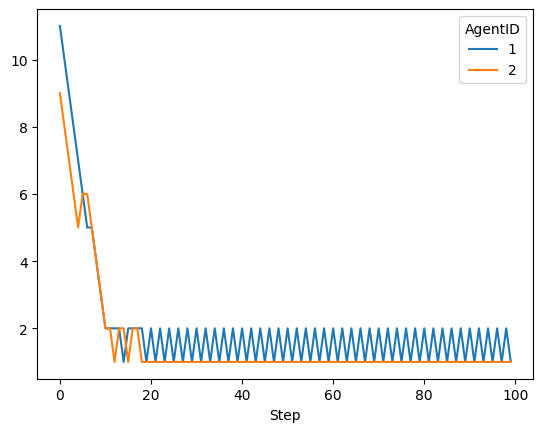

In [75]:
results = model.datacollector.get_agent_vars_dataframe()

results.unstack(level=1).Price.plot()

As the Hotelling's Law model would predict, the two shops converge to a lower and similar price. This contributes to our understading of how competitions occurs between firms in a market for two substitute goods. The model can be further developed to include more shops, more dimensions, and more complex decision making processes.

We may proceed to add three more shops to our model and evaluate the differences.

In [84]:
parameters = {
    "time": {
        "end": 100,
    }
}

model = Hotelling(N=5, parameters=parameters)

model.run_model()

tick[100] 2023-11-25 10:57:15

<Axes: xlabel='Step'>

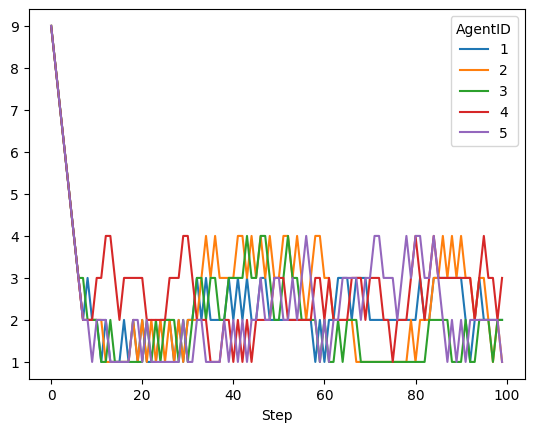

In [85]:
results = model.datacollector.get_agent_vars_dataframe()

results.unstack(level=1).Price.plot()

After extending the model to inlcude 5 shops, we can appretiate how some shops are now able to hold higher prices for longer periods after well advanced time periods. Hotelling (1929) considered that all shops or sellers are a monopoly within the confines of a smaller jurisdiction or area.

We can also explore those relative positions in our grid, the areas of each shop and respective revenues. This example only aims to provide a quick illustration of how to use the ABSESpy package.

## References
Hotelling, H. (1929). Stability in competition. The Economic Journal, 39(153), 41-57.